# LDA 1D Trialwise only (no continuous) 

In [1]:
%matplotlib inline

import sys, pathlib
sys.path.insert(0, str(pathlib.Path().absolute().parent))

from helper_scripts.helperFunctions import *
from helper_scripts.constants import *
from helper_scripts.dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
from helper_scripts.featureBuilder import featureBuilder

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


## Build dataframes and variables needed

In [4]:
# Load datas and concat into one dataframe 

# Load dataset 1
foldername='P001'
filename='part_P001_block_S004'
df1 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

# Load dataset 2
foldername='P001'
filename='part_P001_block_S005'
df2 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

df = pd.concat([df1, df2], ignore_index=True)

In [5]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]

num_to_keep = min(len(focused_df), len(unfocused_df))

focused_df = focused_df.drop(focused_df.sample(len(focused_df) - num_to_keep).index)
unfocused_df = unfocused_df.drop(unfocused_df.sample(len(unfocused_df) - num_to_keep).index)

print("focused len:", len(focused_df), "unfocused len:", len(unfocused_df))


focused len: 420 unfocused len: 420


In [6]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}
for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)

# for row_index,row in med_df.iterrows():
#     dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)
#del dictionary['average norm_mean_first_difference']
#del dictionary['average norm_mean_second_difference']
# keywords_to_keep = ['delta', 'theta', 'alpha', 'beta', 'focused']
# dkeys = list(dictionary.keys())
# for key in dkeys: 
#     if not any(word in key for word in keywords_to_keep):
#         del dictionary[key]
        
feature_df = pd.DataFrame(dictionary)
len(feature_df)

840

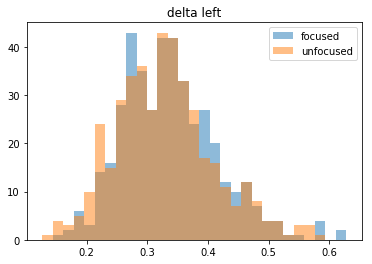

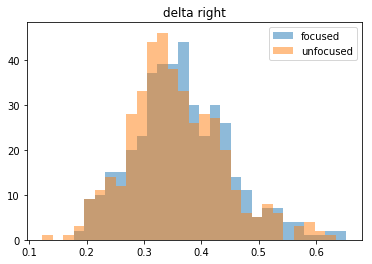

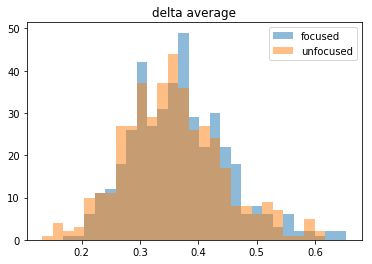

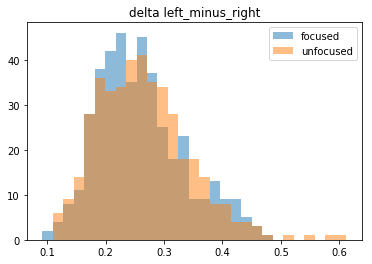

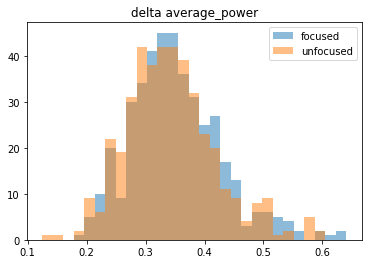

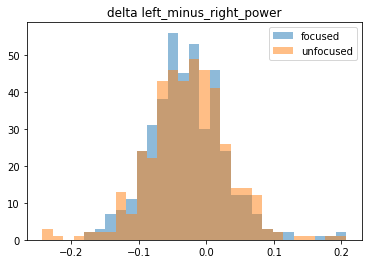

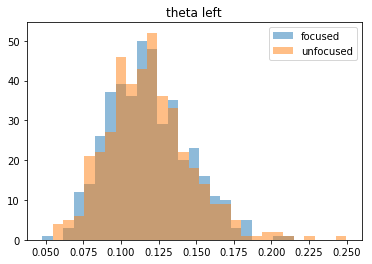

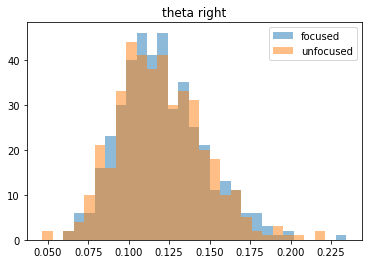

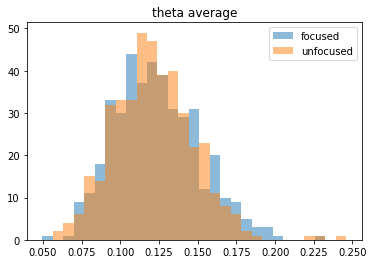

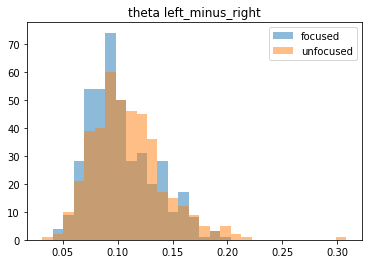

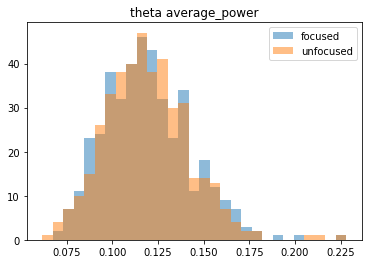

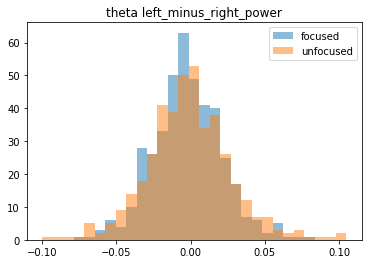

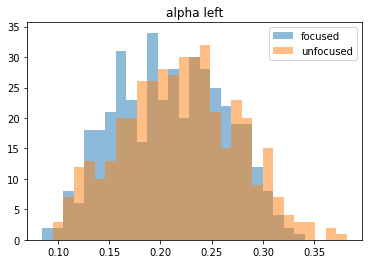

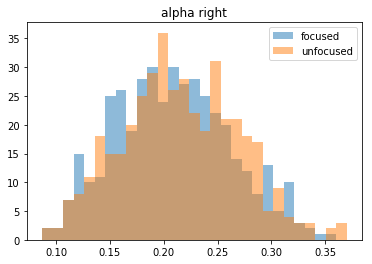

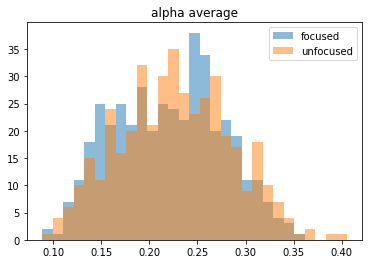

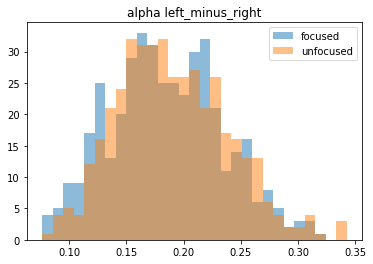

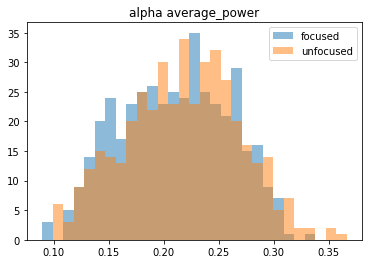

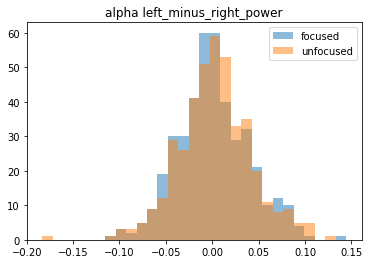

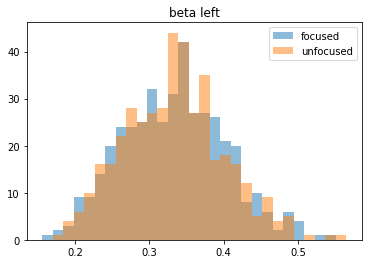

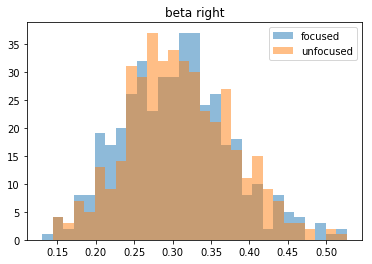

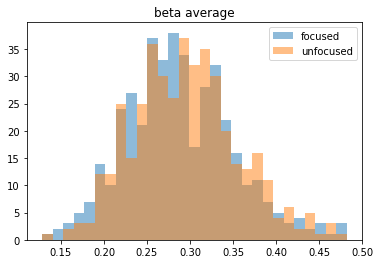

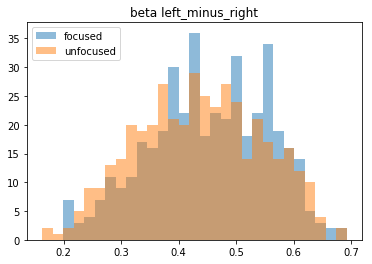

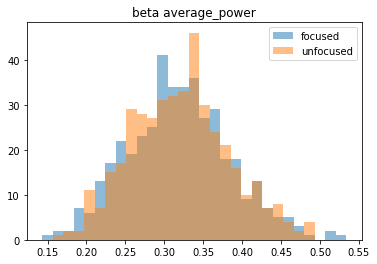

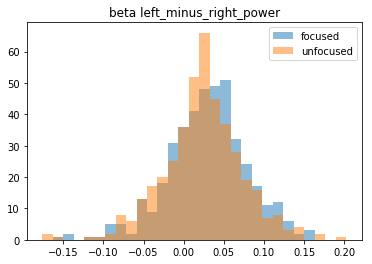

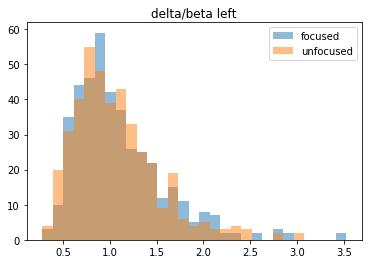

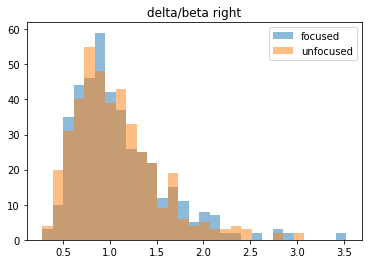

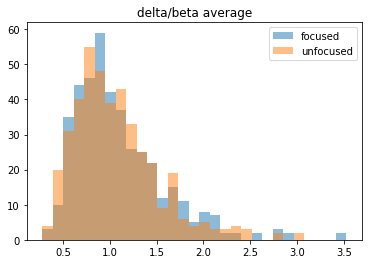

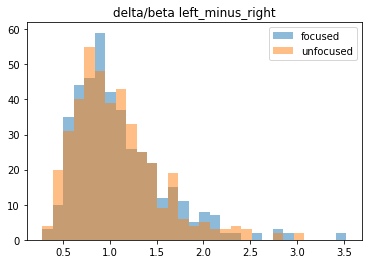

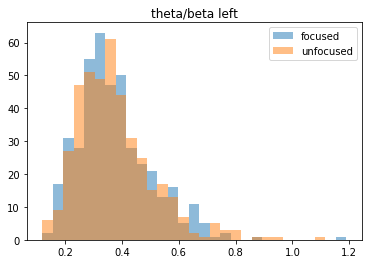

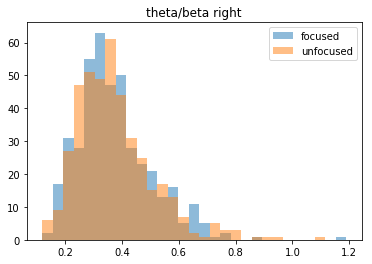

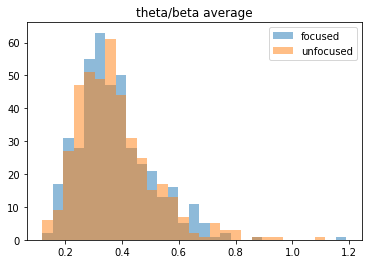

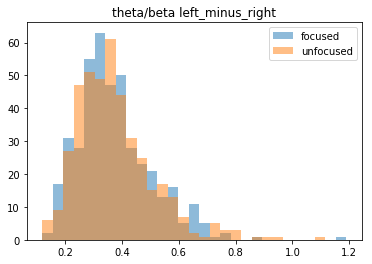

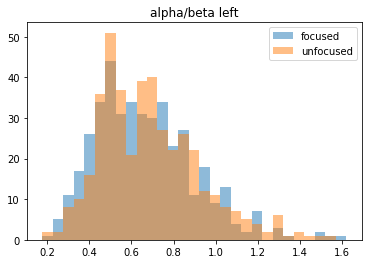

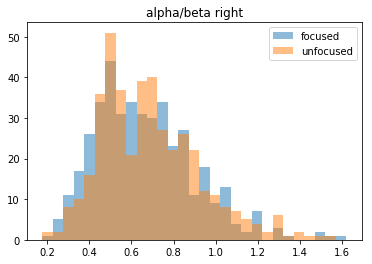

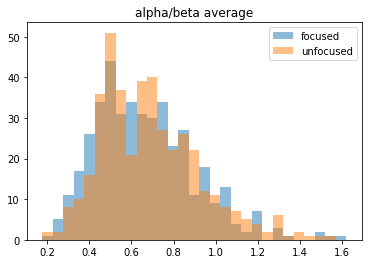

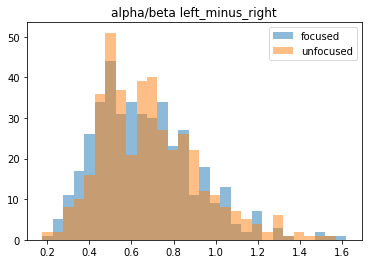

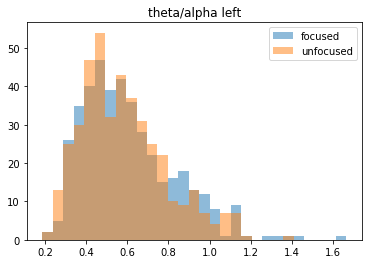

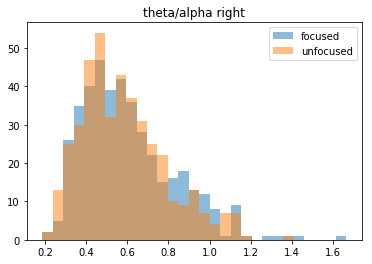

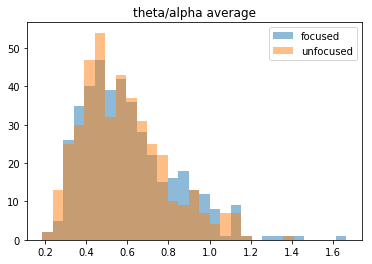

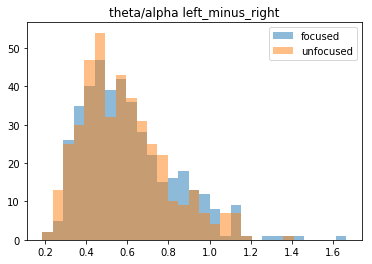

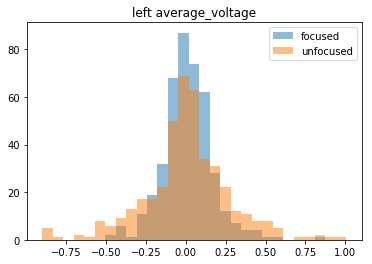

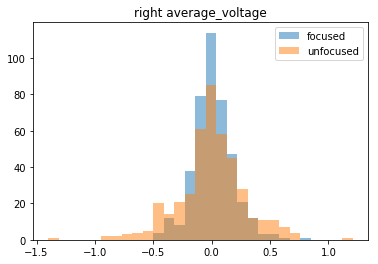

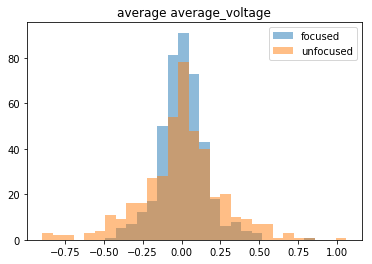

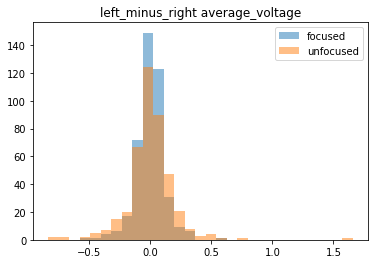

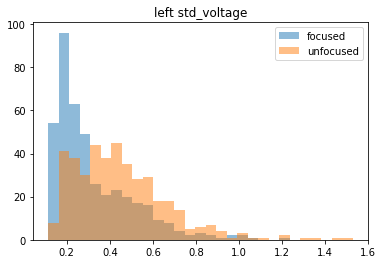

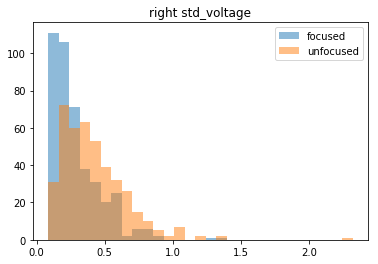

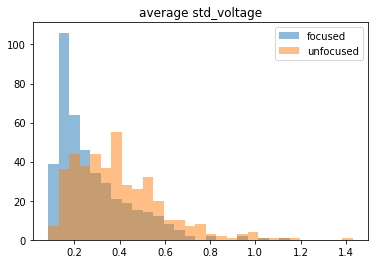

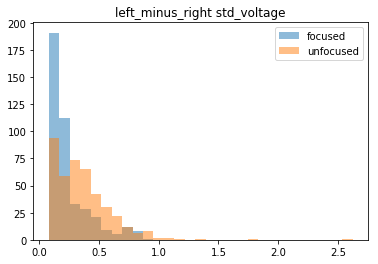

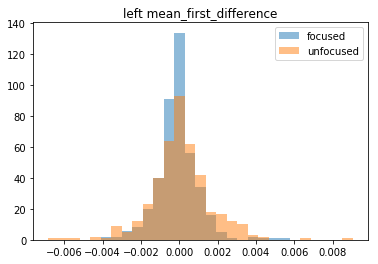

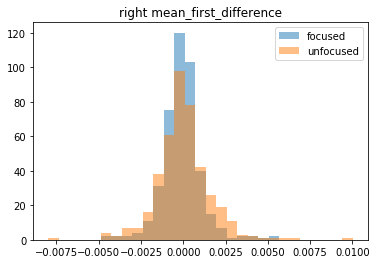

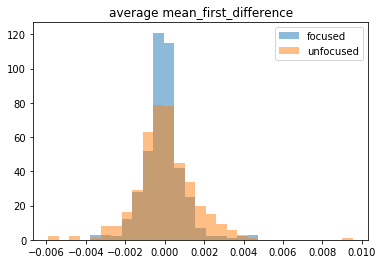

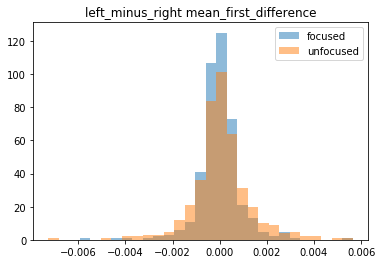

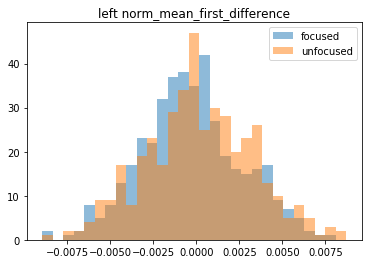

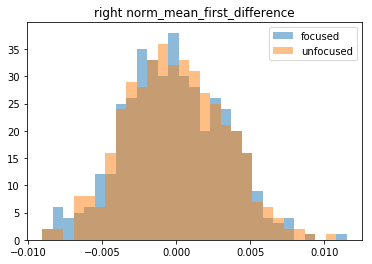

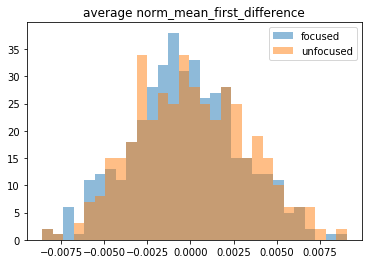

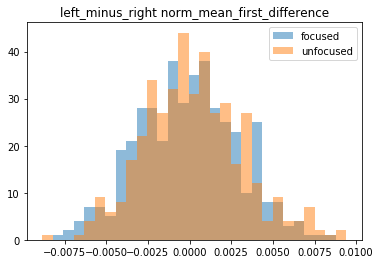

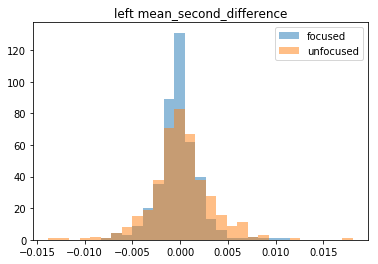

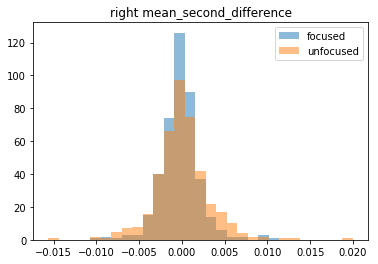

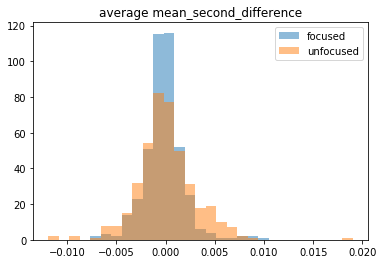

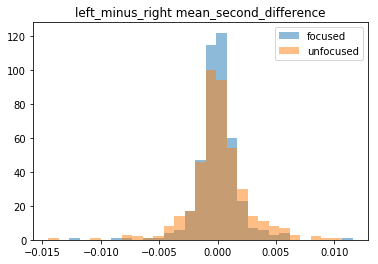

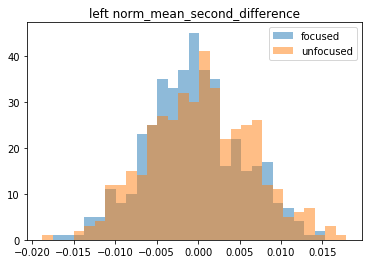

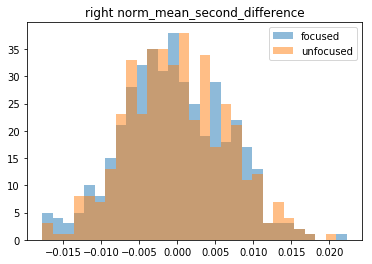

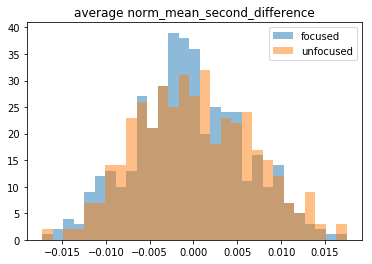

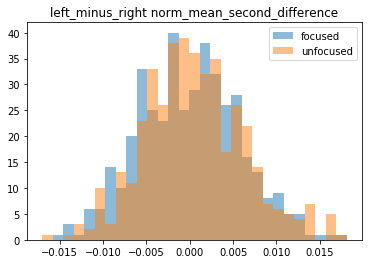

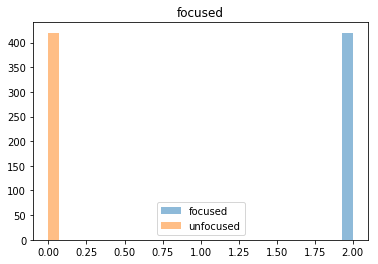

In [7]:
# Plot all feature distributions
for col in feature_df.columns: 
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    
    
    plt.title(col)
    plt.legend()
    plt.show()

In [8]:
# Average the accuracy over X different random samples
# Using LDA to find most heavily weighted features
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    
    z_labels = lda.predict(X_test) #gives you the predicted label for each sample
    z_prob = lda.predict_proba(X_test) #the probability of each sample to belong to each class
    #Predict the response for test dataset
    y_pred = z_labels
    X_test = lda.transform(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA accuracy:", np.mean(np.array(accuracies)))


Accuracy 0.5952380952380952
Accuracy 0.6607142857142857
Accuracy 0.6607142857142857
Accuracy 0.6488095238095238
Accuracy 0.6130952380952381
Accuracy 0.6547619047619048
Accuracy 0.6607142857142857
Accuracy 0.6488095238095238
Accuracy 0.6666666666666666
Accuracy 0.6309523809523809
Avg LDA accuracy: 0.6440476190476192


In [9]:
# Top most effective
num_effective = 10

zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
print("Most significant LDA Coefficients: ")
for elem in sorted_zip_list[:num_effective]:
    print(elem)
print()
for elem in sorted_zip_list[-num_effective:]:
    print(elem)

Most significant LDA Coefficients: 
(-78.26560502644, 'average norm_mean_first_difference')
(-42.607071460970396, 'right norm_mean_second_difference')
(-32.08127409142021, 'left norm_mean_second_difference')
(-17.011173265144436, 'left_minus_right mean_second_difference')
(-10.050939438610053, 'left std_voltage')
(-9.10697130576486, 'beta average')
(-7.141116746723364, 'right mean_first_difference')
(-5.970969070794453, 'left mean_second_difference')
(-5.934713313715674, 'right std_voltage')
(-5.26227804380458, 'alpha left')

(4.425557159186149, 'theta average')
(4.722860638780505, 'left_minus_right norm_mean_second_difference')
(6.054284424801517, 'left mean_first_difference')
(7.606271343936479, 'right mean_second_difference')
(9.307871573139199, 'alpha average')
(10.476204962431105, 'average std_voltage')
(15.478061615081739, 'left_minus_right mean_first_difference')
(33.51226466035847, 'left norm_mean_first_difference')
(54.06971570946623, 'right norm_mean_first_difference')
(65.44

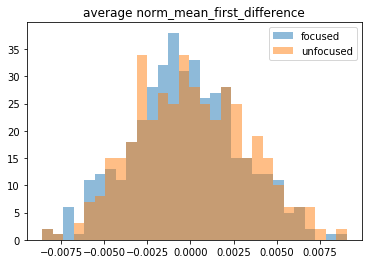

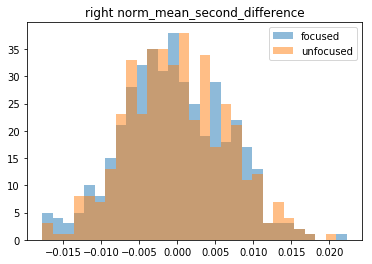

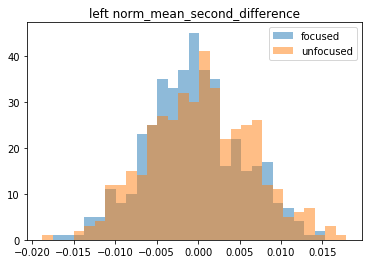

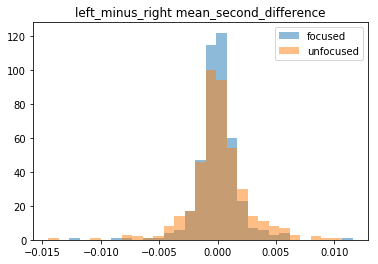

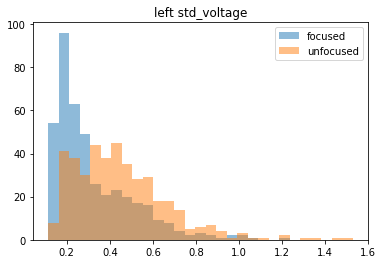

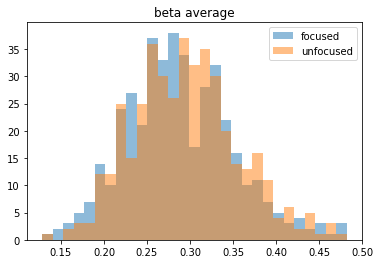

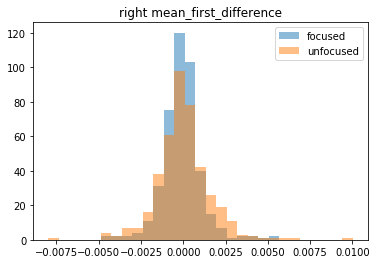

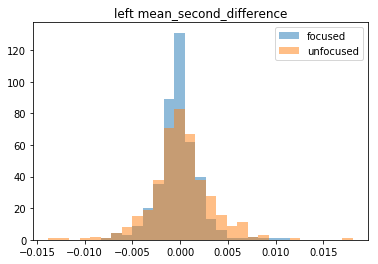

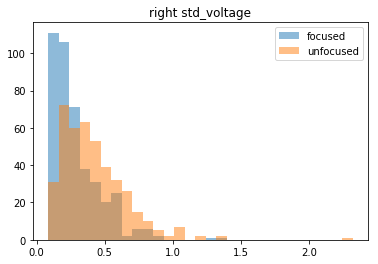

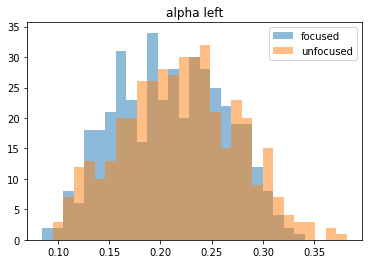

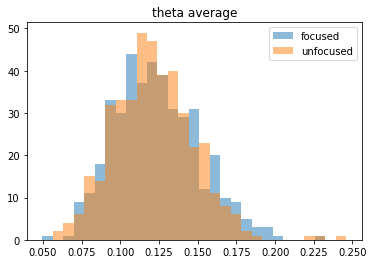

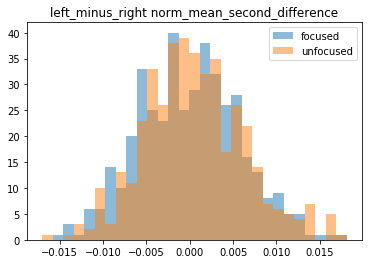

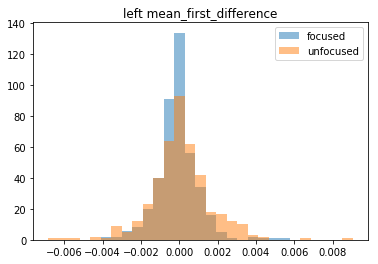

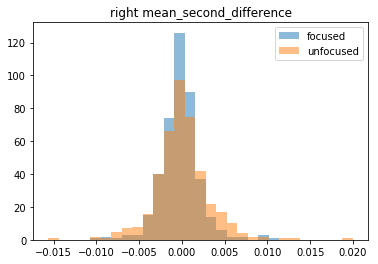

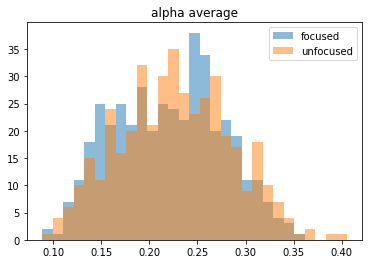

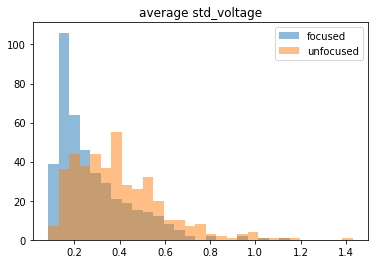

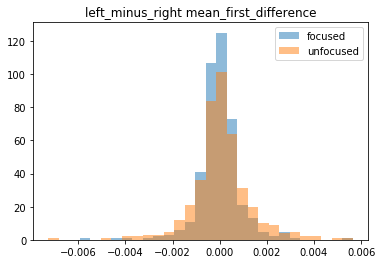

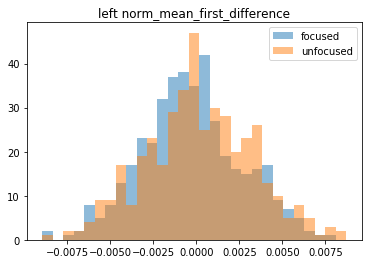

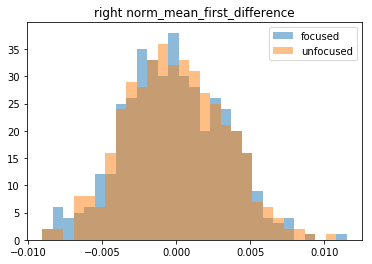

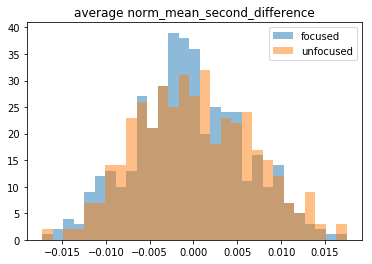

In [10]:
# Top most effective 

for elem in sorted_zip_list[:num_effective]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
   
    plt.title(col)
    plt.legend()
    plt.show()
print("==================================================")
for elem in sorted_zip_list[-num_effective:]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
   
    plt.title(col)
    plt.legend()
    plt.show()
    

LDA explained variance: [1.]


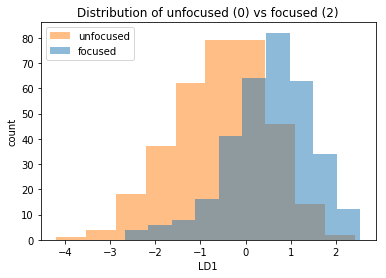

In [11]:
# Visualize LDA model 

class_names={2:"focused", 0:"unfocused"}
colors={2:"C0", 0:"C1"}

print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(X_train, columns=['LDA 1'])
lda_feature_df['focused']=y_train.values

# Plot groups wrt LDA 1 dimension

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.hist(df['LDA 1'].values, alpha=0.5, color=colors[class_name], label=class_names[class_name])

plt.xlabel('LD1')
plt.ylabel("count")
plt.title("Distribution of unfocused (0) vs focused (2)")    
plt.legend()
plt.show()

## LDA manual

In [ ]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [ ]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [ ]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [ ]:
within_class_scatter_matrix.shape

In [ ]:
between_class_scatter_matrix.shape

In [ ]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [ ]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
print("top 10 eigenvalues")
for pair in pairs[:10]:
    print(pair[0])

In [ ]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [ ]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

In [ ]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

In [ ]:
plt.xlabel('LD1')


In [ ]:
plt.xlabel('LD1')
plt.scatter(
    X_lda[:,0],
    y,
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.xlim(-0.0025, 0.0025)